In [22]:
# This notebook was written with the help of ChatGPT (version GPT 5, October 2025), and checked by Lucie Perez

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

In [24]:
sns.set_theme(style="whitegrid", context="talk")  # good for papers
plt.rcParams["figure.dpi"] = 200

In [25]:
df = pd.read_csv("data/clause_number_results_assessment.csv")

In [26]:
df.head(5)

,category,False,True,percentage,model_temp,size,status
0,complex,286,0,0.0,GPT-4o mini (T=0),large,base
1,simple_1_clause,237,27,10.2,GPT-4o mini (T=0),large,base
2,simple_2_clauses,183,233,56.0,GPT-4o mini (T=0),large,base
3,simple_3_clauses,329,155,32.0,GPT-4o mini (T=0),large,base
4,simple_4_clauses,349,77,18.1,GPT-4o mini (T=0),large,base


In [27]:
# 1) Order sizes for correct left→right plotting
size_order = ['small', 'medium', 'large']
df['size'] = pd.Categorical(df['size'], categories=size_order, ordered=True)

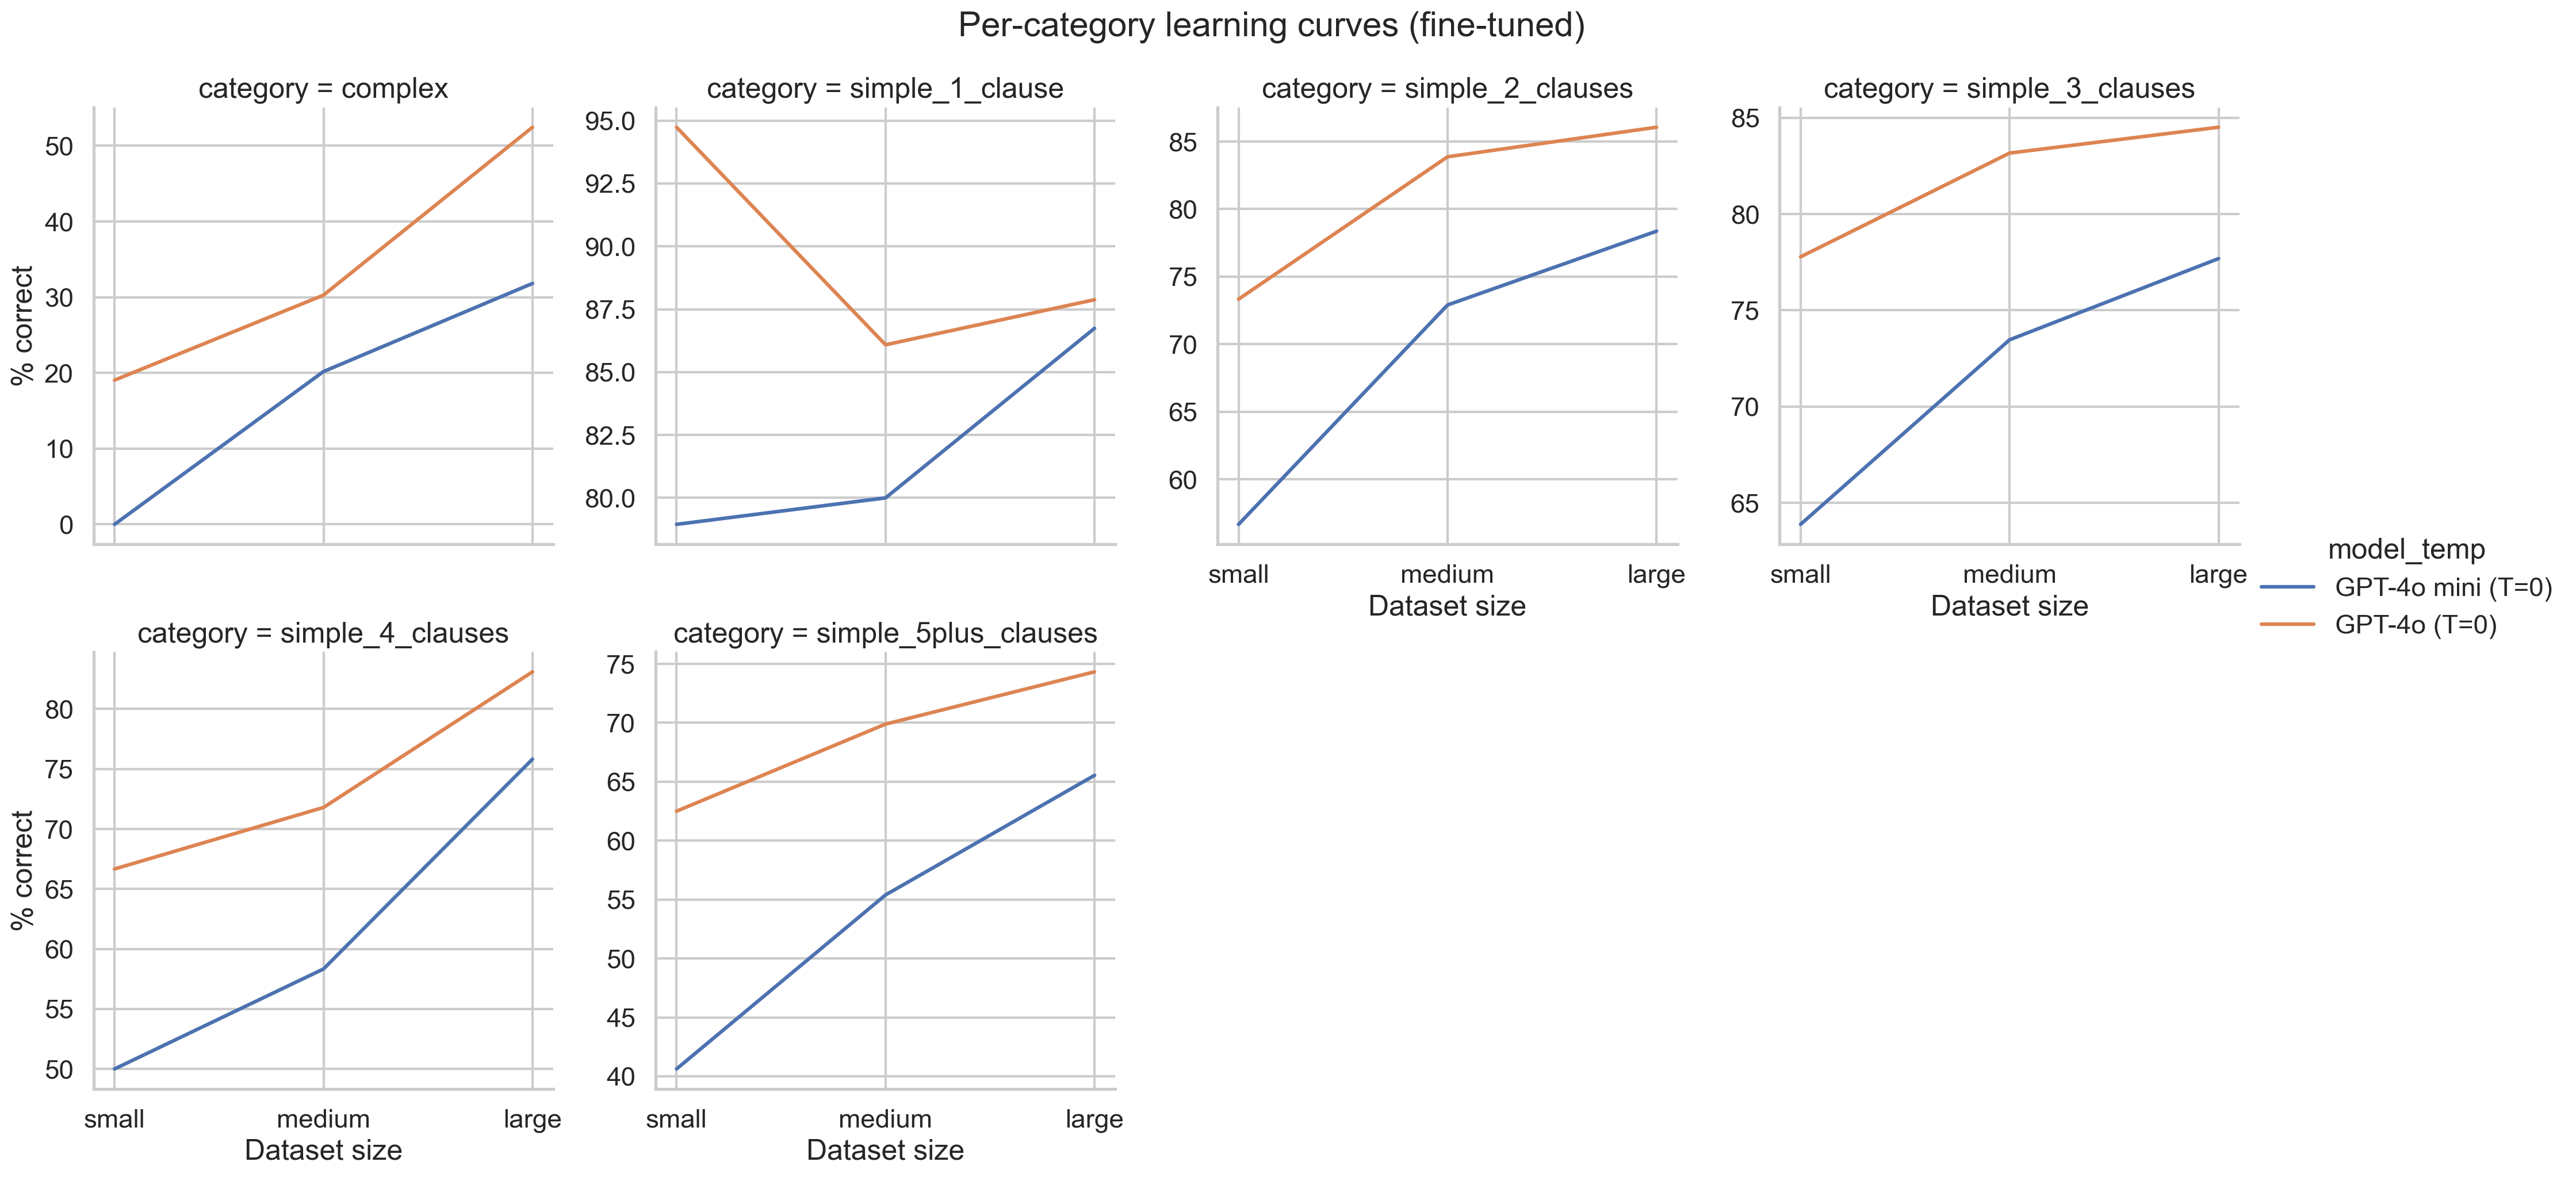

In [28]:
# 2) Per-category accuracy curves (fine-tuned models)
df_cat = df.copy()
df_cat['acc'] = (df_cat['True'] / (df_cat['True'] + df_cat['False'])) * 100

g = sns.relplot(
    data=df_cat[df_cat['status'] == 'fine-tuned'],
    x='size', y='acc',
    hue='model_temp',
    col='category', col_wrap=4,
    kind='line',
    markers=True, dashes=True,
    facet_kws={'sharey': False}
)
g.set_axis_labels('Dataset size', '% correct')
g.fig.suptitle('Per-category learning curves (fine-tuned)', y=1.03)
plt.show()

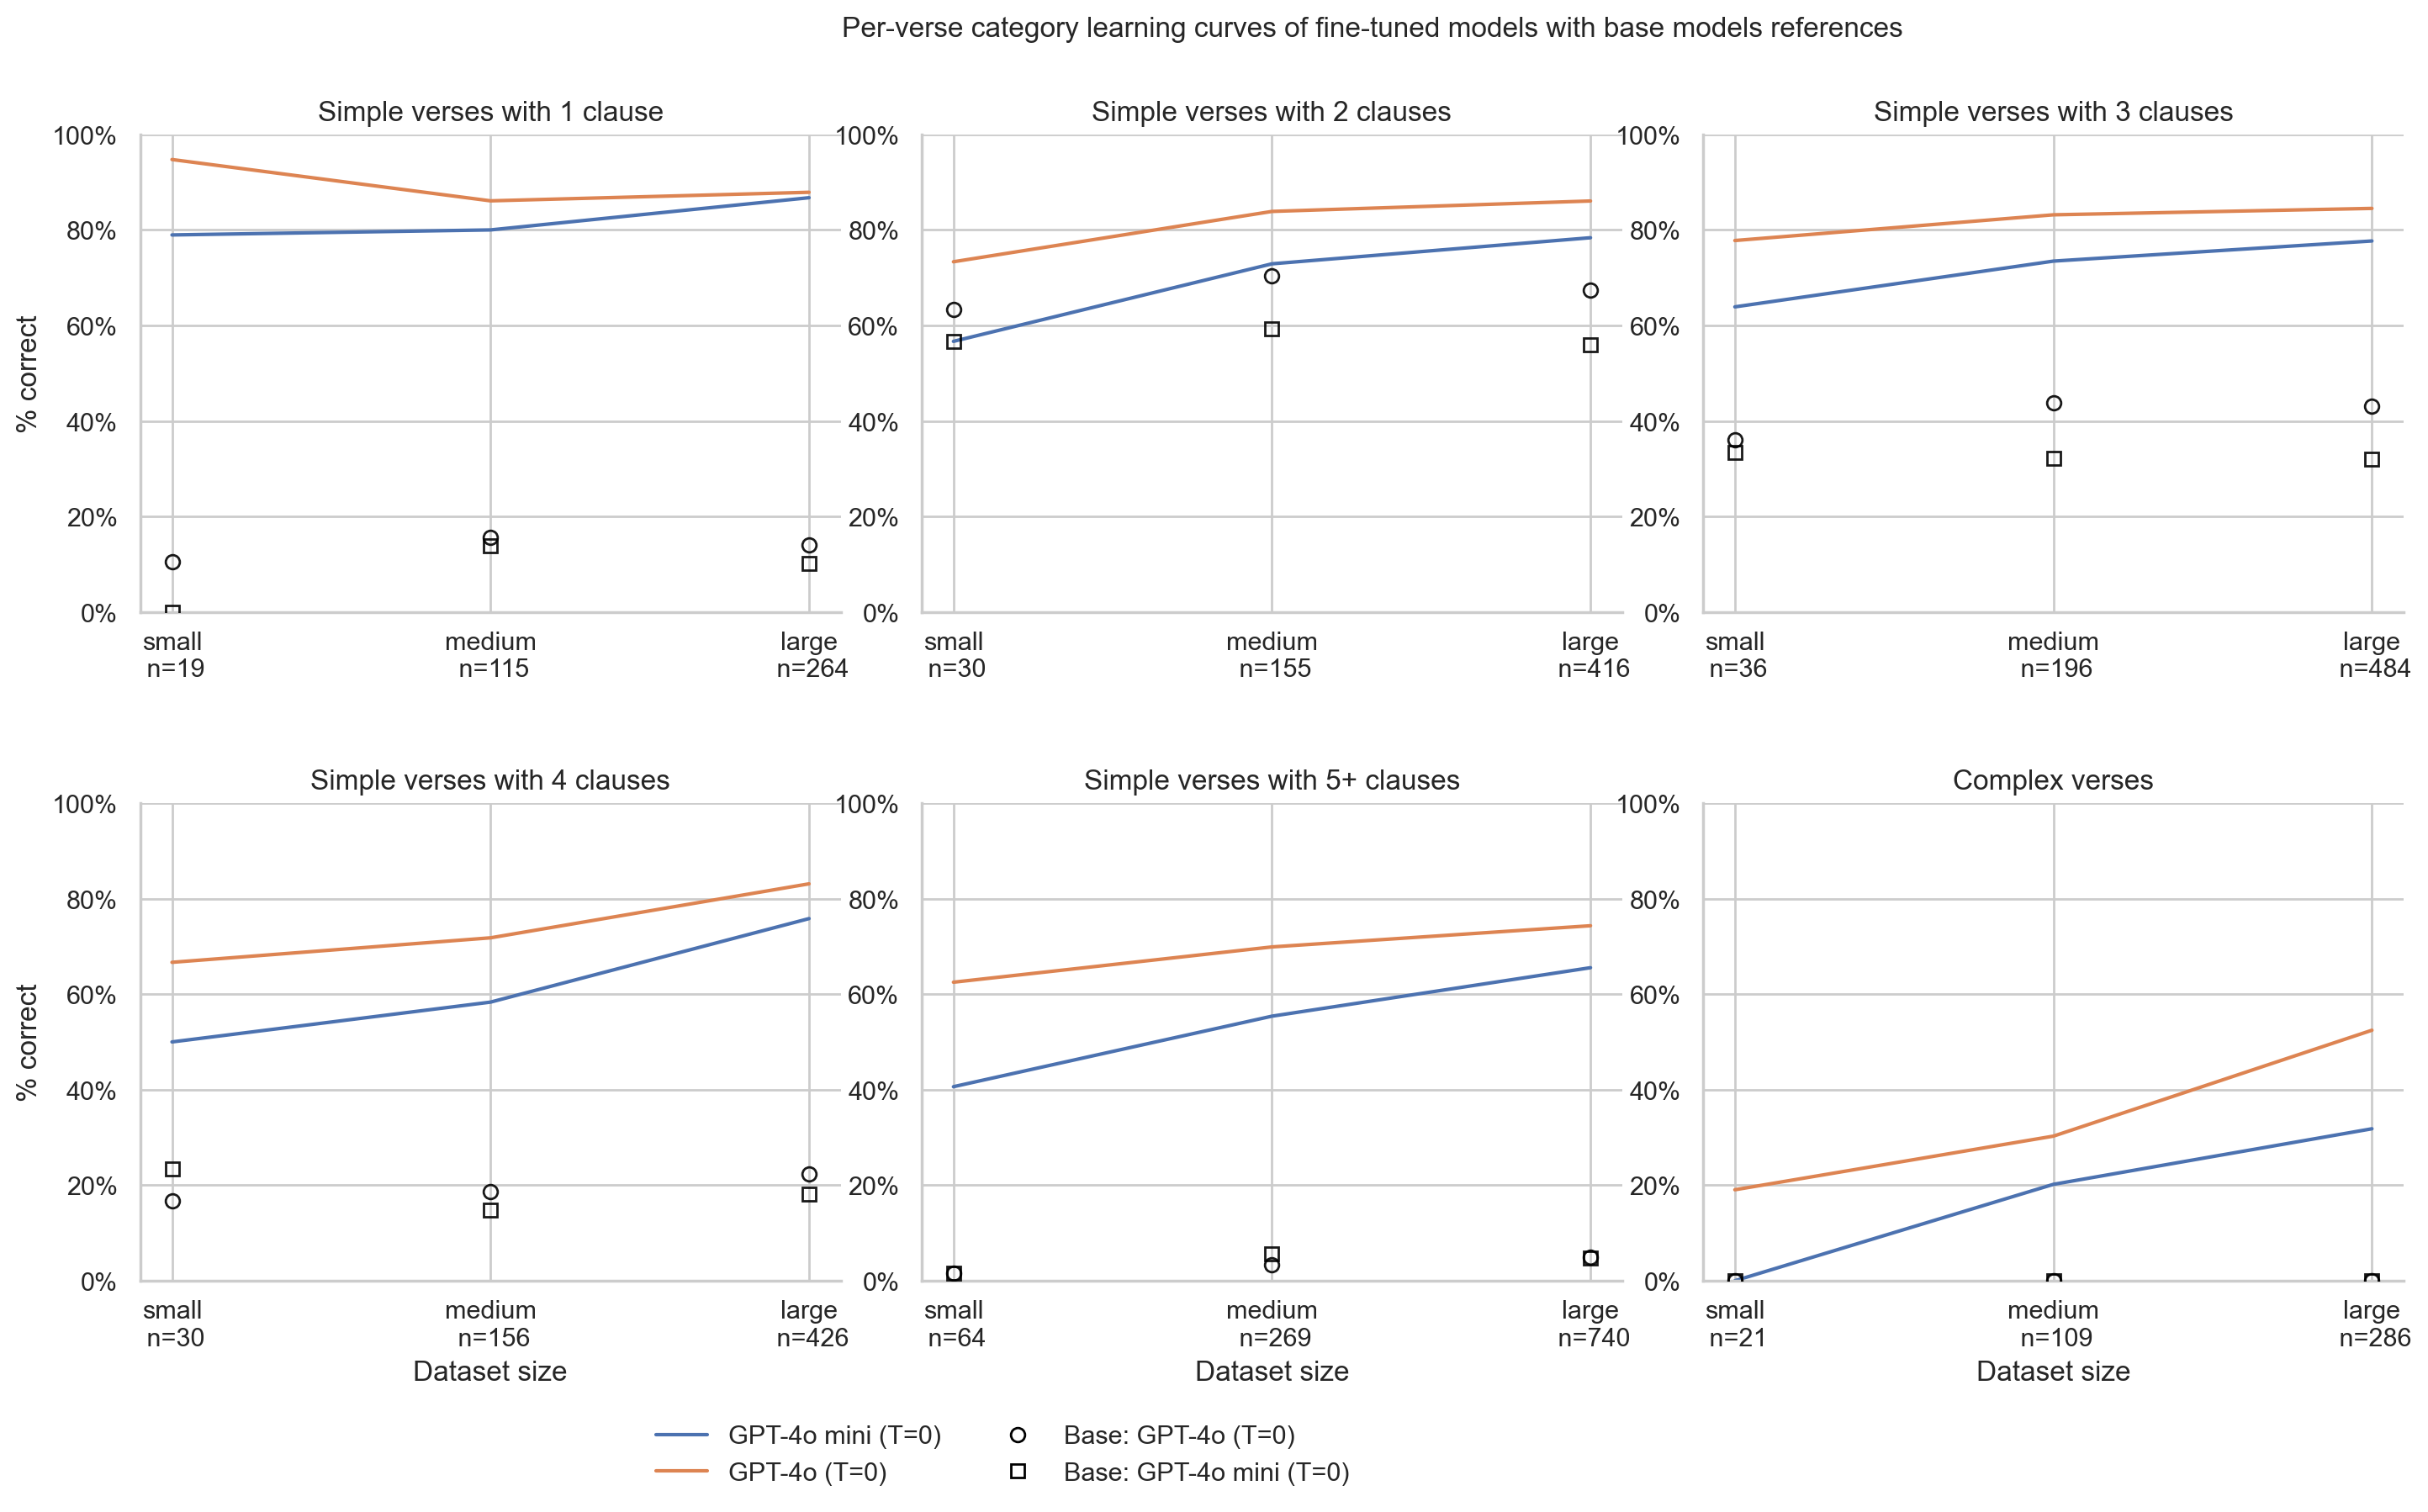

In [37]:
# 3) Per-category accuracy curves (fine-tuned models) with more details
# --- Base setup ---
sns.set_theme(style="whitegrid")
size_order = ["small", "medium", "large"]

df_cat = df.copy()
df_cat["size"] = pd.Categorical(df_cat["size"], categories=size_order, ordered=True)
df_cat["acc"] = 100 * df_cat["True"] / (df_cat["True"] + df_cat["False"])
df_cat["n"]   = df_cat["True"] + df_cat["False"]

# One n per (raw category, size); avoid double-counting across models/status
n_map = (
    df_cat.groupby(["category", "size"], as_index=False)
          .agg(n=("n", "max"))
)
# Keyed by raw category + size string
n_label_map = {
    (row["category"], str(row["size"])): f'{row["size"]}\n n={int(row["n"])}'
    for _, row in n_map.iterrows()
}

# Raw categories (facet keys)
category_order = [
    "simple_1_clause",
    "simple_2_clauses",
    "simple_3_clauses",
    "simple_4_clauses",
    "simple_5plus_clauses",
    "complex"
]

# Pretty titles
title_map = {
    "simple_1_clause": "Simple verses with 1 clause",
    "simple_2_clauses": "Simple verses with 2 clauses",
    "simple_3_clauses": "Simple verses with 3 clauses",
    "simple_4_clauses": "Simple verses with 4 clauses",
    "simple_5plus_clauses": "Simple verses with 5+ clauses",
    "complex": "Complex verses"
}

# --- (Optional) Order facets by difficulty (fine-tuned, LARGE size) ---
facet_order = (
    df_cat[(df_cat["status"] == "fine-tuned") & (df_cat["size"] == "large")]
    .groupby("category", as_index=False)["acc"].mean()
    .sort_values("acc")["category"].tolist()
)

# --- Plot fine-tuned learning curves (use RAW category as facet key) ---
g = sns.relplot(
    data=df_cat[df_cat["status"] == "fine-tuned"],
    x="size", y="acc",
    hue="model_temp",
    col="category", col_wrap=3,          # <- raw category column
    kind="line",
    markers=True, dashes=True,
    facet_kws={"sharey": False, "sharex": False},
    col_order=category_order,            # <- order based on raw keys
    height=4, aspect=1.2
)
g.set_axis_labels("Dataset size", "% correct")
g.set_titles("{col_name}")
g.set(xlim=(-0.1, None), ylim=(0, 100))

# Format y-axis as %
for ax in g.axes.ravel():
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.0f}%"))

# --- Overlay BASE results as hollow markers (context, not curves) ---
base_points = (
    df_cat[df_cat["status"] == "base"]
    .groupby(["category", "model_temp", "size"], as_index=False)
    .agg(acc=("acc", "mean"))
)

# Assign a distinct marker per base model
model_order = sorted(df_cat['model_temp'].unique())
_markers = ['o','s','^','D','P','X','v','>','<','*']
marker_map = {m: _markers[i % len(_markers)] for i, m in enumerate(model_order)}

# Map axes by RAW facet keys (reliable) instead of titles
ax_by_cat = {cat: ax for cat, ax in zip(g.col_names, g.axes.ravel())}

# Plot base dots using RAW category keys
for _, row in base_points.iterrows():
    cat = row["category"]
    ax = ax_by_cat.get(cat)
    if ax is None:
        continue

    # get true tick centers from the axis
    ticks = ax.get_xticks()
    tick_map = dict(zip(size_order, ticks))
    x_pos = tick_map.get(row["size"])
    if x_pos is None:
        continue

    ax.plot(
        x_pos, row["acc"],
        marker=marker_map.get(row["model_temp"], 'o'),
        mfc="none", mec="black", mew=1.0, linestyle="none", alpha=0.9,
        zorder=5
    )

# --- Legend & layout ---
# Add proxy legend entries for base markers
base_proxies = [
    Line2D([0],[0], marker=marker_map[m], mfc='none', mec='black',
           linestyle='none', label=f'Base: {m}')
    for m in model_order
]
first_ax = g.axes.ravel()[0]
handles, labels = first_ax.get_legend_handles_labels()

# Remove seaborn's default legend safely
if g._legend is not None:
    g._legend.remove()

# Place combined legend (you can keep this inside or move below; here: lower right)
g.fig.legend(
    handles + base_proxies,
    labels + [h.get_label() for h in base_proxies],
    loc="upper right",          # attach the TOP of the legend...
    bbox_to_anchor=(0.5, 0.01), # ...to a point below the figure (y < 0)
    ncol=max(2, (len(handles) + len(base_proxies)) // 2),
    frameon=False
)


# --- Replace x tick labels with "size, n=XX" using RAW category keys ---
for cat, ax in ax_by_cat.items():
    sizes_present = [s for s in size_order if (cat, s) in n_label_map]
    tick_positions = [size_order.index(s) for s in sizes_present]
    tick_labels = [n_label_map[(cat, s)] for s in sizes_present]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.tick_params(axis='x', pad=2)

# --- Apply pretty titles LAST (so lookups above use raw keys) ---
for ax, raw_cat in zip(g.axes.ravel(), g.col_names):
    ax.set_title(title_map.get(raw_cat, raw_cat))

# --- Figure title & spacing ---
g.fig.suptitle(
    "Per-verse category learning curves of fine-tuned models with base models references",
    y=1.04, fontsize=12, ha="center", x=0.5
)
g.fig.subplots_adjust(hspace=0.4, bottom=0.10)

plt.show()

In [38]:
g.savefig("figures/learning_curve_verse_category.png", dpi=300, bbox_inches='tight')